# 正則化

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import torchvision
from torchvision import models, transforms

%load_ext autoreload
%autoreload 2
import utils

## L2正則(重み減衰)のスクラッチ

L2正則
- モデルのパラメータを取得し、重みに対してフロベニウス正則を損失関数に加える
    - torch.linalg.norm()でフロベニウスノルムを計算
- 正則化の強さを調整する係数weight_decayを使う
- 学習ループにあることを想定して、lossに追加していく(実際のlossの計算等は省略する)

In [2]:
X = torch.tensor([[1., 2., 3. ], [4., 5., 6.]])
X.shape

torch.Size([2, 3])

In [3]:
X

tensor([[1., 2., 3.],
        [4., 5., 6.]])

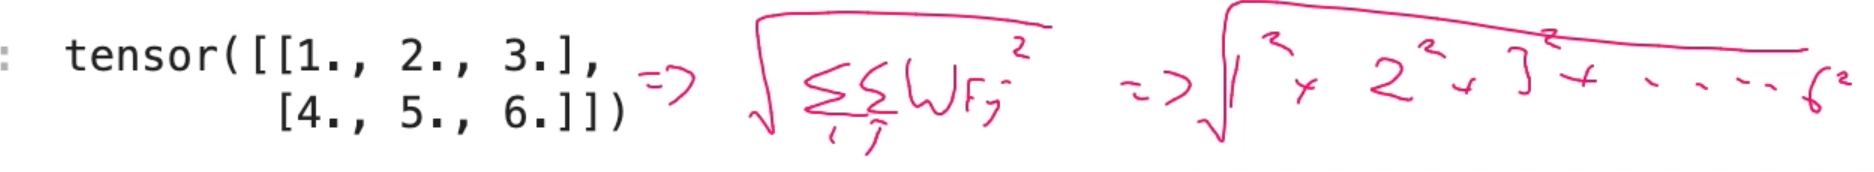

In [4]:
# フロベニウスノルム
torch.linalg.norm(X)

tensor(9.5394)

In [5]:
# フロベニウスノルムは各要素を2乗して合計し最後にルートを取る
torch.sqrt(torch.sum(X**2))

tensor(9.5394)

In [6]:
# GAPなしのモデル
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1
    
    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(128, 10)
    # nn.Linear(32, 10)
    # 10
)

In [8]:
l2_reg

tensor(23.6656, grad_fn=<AddBackward0>)

## PytorchでL2正則を使う

- torch.nn.optim.class(weight_decay)でL2正則を利用できる
    - 例: torch.nn.optim.SGD(model.parameters(), lr=0.03, weight_decay=0.01)

In [9]:
optim.SGD(conv_model.parameters(), lr=0.03, weight_decay=0.01)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0.01
)

## L2正則の有無でのモデル比較

- CIFAR10データで学習
- GAP層を使ったCNNを使用
- 10epochで重み減衰有りのOptimizerと無しのOptimizerでlearning curveを比較

In [10]:
# モデルを返す関数の定義
def get_conv_model():
    return nn.Sequential(
    # 3x28x28
    nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1
    
    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(128, 10)
    # nn.Linear(32, 10)
    # 10
)

In [11]:
# モデル作成(L2無しモデルと有りモデル)
conv_model = get_conv_model()
conv_model_l2 = get_conv_model()

# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # CIFAR10用
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
train_dataset = torchvision.datasets.CIFAR10('.cifar10_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10('.cifar10_data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)

# Optimizer
opt = optim.SGD(conv_model.parameters(), lr=0.03)
opt_l2 = optim.SGD(conv_model_l2.parameters(), lr=0.03, weight_decay=0.001)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# L2無しver
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 20)
# L2有りver
train_losses_l2, val_losses_l2, val_accuracies_l2 = utils.learn(conv_model_l2, train_loader, val_loader, opt_l2, F.cross_entropy, 20)

epoch: 0: train error: 2.294705472638845, validation error: 2.2566811887523794, validation accuracy: 0.18443433544303797


epoch: 1: train error: 2.0413581727410826, validation error: 1.883283192598367, validation accuracy: 0.3251582278481013


epoch: 2: train error: 1.8132593576865428, validation error: 1.7147690223742136, validation accuracy: 0.3861748417721519


epoch: 3: train error: 1.7015907959559995, validation error: 1.6323201943047438, validation accuracy: 0.40941455696202533


epoch: 4: train error: 1.6291892062062803, validation error: 1.5704581978954846, validation accuracy: 0.4264240506329114


epoch: 5: train error: 1.5677848136638437, validation error: 1.5146519473836393, validation accuracy: 0.4506526898734177


epoch: 6: train error: 1.522337445212752, validation error: 1.4969499262073371, validation accuracy: 0.4579707278481013


epoch: 7: train error: 1.4859552987091376, validation error: 1.4733829060687293, validation accuracy: 0.46924446202531644


epoch: 8: train error: 1.456151556480876, validation error: 1.4759877135482016, validation accuracy: 0.46410205696202533


epoch: 9: train error: 1.428482983118433, validation error: 1.4197144885606403, validation accuracy: 0.4854628164556962


epoch: 10: train error: 1.4038353560830625, validation error: 1.3939882486681394, validation accuracy: 0.49406645569620256


epoch: 11: train error: 1.384662830311319, validation error: 1.380071763750873, validation accuracy: 0.5022745253164557


epoch: 12: train error: 1.3688494951828667, validation error: 1.3664473913892914, validation accuracy: 0.5095925632911392


epoch: 13: train error: 1.346966886154526, validation error: 1.4180373074133186, validation accuracy: 0.49297863924050633


epoch: 14: train error: 1.3315843508371612, validation error: 1.3320598451397088, validation accuracy: 0.5215585443037974


epoch: 15: train error: 1.31739122727338, validation error: 1.3461670634112781, validation accuracy: 0.5106803797468354


epoch: 16: train error: 1.3028421395879877, validation error: 1.3505392119854311, validation accuracy: 0.5154272151898734


epoch: 17: train error: 1.2886475785004208, validation error: 1.3441227689574036, validation accuracy: 0.5167128164556962


epoch: 18: train error: 1.279475414234659, validation error: 1.34422767162323, validation accuracy: 0.5229430379746836


epoch: 19: train error: 1.2683744647008988, validation error: 1.3088791204404226, validation accuracy: 0.533623417721519


epoch: 0: train error: 2.2671941887692113, validation error: 2.119727554200571, validation accuracy: 0.24920886075949367


epoch: 1: train error: 1.995934568097829, validation error: 1.8954881776737262, validation accuracy: 0.3112143987341772


epoch: 2: train error: 1.838826079807623, validation error: 1.7518360463878777, validation accuracy: 0.37757120253164556


epoch: 3: train error: 1.7110386638690138, validation error: 1.6423328390604333, validation accuracy: 0.40882120253164556


epoch: 4: train error: 1.6284568983575571, validation error: 1.5710384332681004, validation accuracy: 0.4462025316455696


epoch: 5: train error: 1.5659950465497459, validation error: 1.5882778922213783, validation accuracy: 0.43473101265822783


epoch: 6: train error: 1.5156867751075178, validation error: 1.4790809486485734, validation accuracy: 0.4699367088607595


epoch: 7: train error: 1.4761924822921948, validation error: 1.4648376808890813, validation accuracy: 0.47310126582278483


epoch: 8: train error: 1.4403917938851944, validation error: 1.4191711824151534, validation accuracy: 0.4876384493670886


epoch: 9: train error: 1.4107184480218327, validation error: 1.4290359427657309, validation accuracy: 0.48694620253164556


epoch: 10: train error: 1.3817639911876005, validation error: 1.4241418974309028, validation accuracy: 0.4910996835443038


epoch: 11: train error: 1.36081824308771, validation error: 1.4678885966916628, validation accuracy: 0.4832871835443038


epoch: 12: train error: 1.3382712377001866, validation error: 1.3552723851384996, validation accuracy: 0.5222507911392406


epoch: 13: train error: 1.3192132226646405, validation error: 1.339019321188142, validation accuracy: 0.5174050632911392


epoch: 14: train error: 1.3028041490203583, validation error: 1.3109644183629676, validation accuracy: 0.5317444620253164


epoch: 15: train error: 1.2850965697442174, validation error: 1.3804789811750002, validation accuracy: 0.515625


epoch: 16: train error: 1.269401743893733, validation error: 1.320754799661757, validation accuracy: 0.532931170886076


epoch: 17: train error: 1.2588574053991177, validation error: 1.2897413825686974, validation accuracy: 0.5362935126582279


epoch: 18: train error: 1.241271682102662, validation error: 1.2885138535801368, validation accuracy: 0.5315466772151899


epoch: 19: train error: 1.2320751098110854, validation error: 1.2623080875300154, validation accuracy: 0.5457871835443038


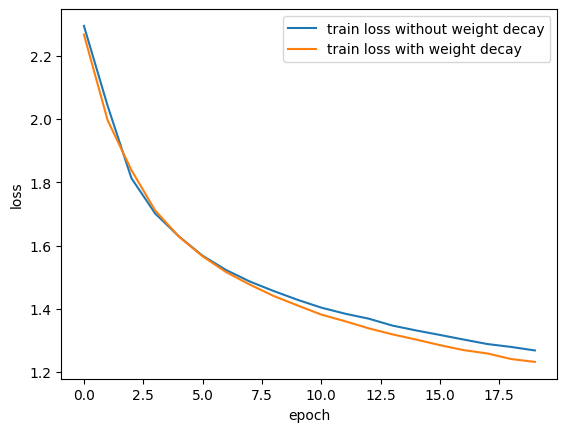

In [13]:
plt.plot(train_losses, label='train loss without weight decay')
plt.plot(train_losses_l2, label='train loss with weight decay')
# plt.plot(val_losses_l2, label='val loss with weight decay')
# plt.plot(val_losses, label='val loss without weight decay')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

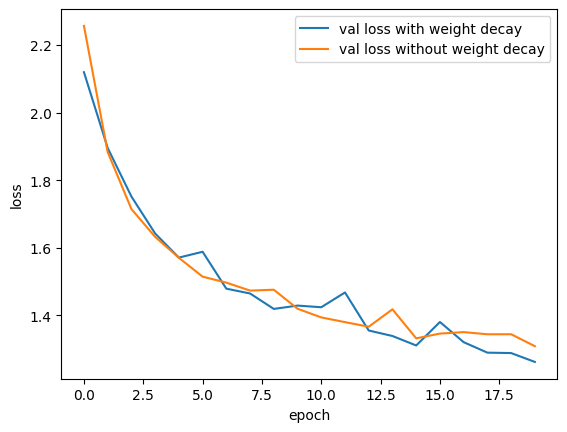

In [14]:
# plt.plot(train_losses, label='train loss without weight decay')
# plt.plot(train_losses_l2, label='train loss with weight decay')
plt.plot(val_losses_l2, label='val loss with weight decay')
plt.plot(val_losses, label='val loss without weight decay')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

## Dropoutのスクラッチ実装

- reluの後にdropoutさせる

In [27]:
def dropout(X, drop_p):
    keep_p = 1 - drop_p
    mask = (torch.rand(X.shape) < keep_p)
    return X * mask / keep_p

In [28]:
X = torch.randn((100, 100))
dropout_X = dropout(X, 0.3)
dropout_X

tensor([[ 4.1815,  0.1834, -0.3583,  ..., -0.0000,  1.5903,  0.0719],
        [ 0.0000, -0.0000,  0.0000,  ...,  2.2143,  1.1589, -0.0000],
        [ 0.0000,  1.1327,  2.7748,  ...,  0.0076, -1.0166, -0.5279],
        ...,
        [-0.0085,  0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000,  1.2093,  ...,  0.3732,  2.2545,  1.0917],
        [-0.5217,  2.2103, -2.2885,  ...,  1.2500, -0.0258, -0.0000]])

In [16]:
# 以下、メモ
X = torch.randn((100, 100))
keep_p = 0.3  
mask = (torch.rand(X.shape) < keep_p)

In [17]:
mask

tensor([[False, False,  True,  ..., False, False, False],
        [False,  True,  True,  ...,  True, False,  True],
        [False, False, False,  ...,  True,  True, False],
        ...,
        [False,  True, False,  ...,  True,  True,  True],
        [ True, False,  True,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False]])

In [18]:
X * mask

tensor([[-0.0000,  0.0000, -2.3013,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.5710,  0.5472,  ..., -0.6614,  0.0000,  0.2373],
        [ 0.0000, -0.0000,  0.0000,  ..., -0.1794,  0.5317,  0.0000],
        ...,
        [-0.0000, -0.7051,  0.0000,  ..., -0.2078,  0.8022,  0.2132],
        [-0.4261, -0.0000, -1.5372,  ..., -0.0000, -0.0000, -0.2838],
        [-0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0000]])

In [19]:
(X * mask).sum()

tensor(-24.0838)

In [23]:
# ReLUを適用した後にDropoutをすると，学習時と予測時でスケールが変わるので/keep_pでリスケールしスケールを合わせる
def relu(X):
    return torch.clamp(X, min=0)
relu_out = relu(X)
keep_p = 0.5
mask = torch.rand(X.shape) < keep_p
print((relu_out * mask).sum() / keep_p)
print(relu_out.sum())

tensor(3934.6482)
tensor(3960.8181)


## PytorchのDropoutを使う
- nn.Dropout()
    - 引数pにはdropする確率を渡す

In [26]:
model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(20, 10)
)

In [27]:
model

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=20, out_features=10, bias=True)
)